In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()

# Ants and Bees tutorial: finetuning with pytorch

In [5]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
class_names

['ants', 'bees']

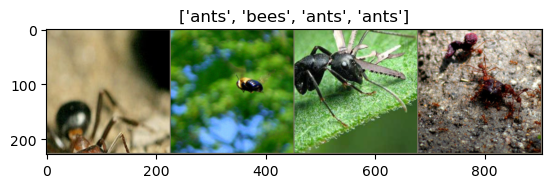

In [6]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [7]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model

In [8]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [9]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/riikoro/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:36<00:00, 1.29MB/s]


In [10]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5773 Acc: 0.7131
val Loss: 0.2915 Acc: 0.8758

Epoch 1/24
----------
train Loss: 0.5209 Acc: 0.7951
val Loss: 0.2146 Acc: 0.9150

Epoch 2/24
----------
train Loss: 0.6439 Acc: 0.7746
val Loss: 0.3835 Acc: 0.8366

Epoch 3/24
----------
train Loss: 0.6392 Acc: 0.7172
val Loss: 0.6961 Acc: 0.7451

Epoch 4/24
----------
train Loss: 0.4132 Acc: 0.8238
val Loss: 0.3968 Acc: 0.8431

Epoch 5/24
----------
train Loss: 0.4164 Acc: 0.8033
val Loss: 0.2720 Acc: 0.8889

Epoch 6/24
----------
train Loss: 0.4909 Acc: 0.7951
val Loss: 0.5945 Acc: 0.7974

Epoch 7/24
----------
train Loss: 0.3225 Acc: 0.8402
val Loss: 0.2684 Acc: 0.8954

Epoch 8/24
----------
train Loss: 0.3333 Acc: 0.8566
val Loss: 0.2458 Acc: 0.9085

Epoch 9/24
----------
train Loss: 0.3644 Acc: 0.8607
val Loss: 0.3004 Acc: 0.8954

Epoch 10/24
----------
train Loss: 0.2743 Acc: 0.8893
val Loss: 0.2203 Acc: 0.9216

Epoch 11/24
----------
train Loss: 0.3145 Acc: 0.8566
val Loss: 0.2548 Acc: 0.9020

Ep

/home/riikoro/anaconda3/lib/python3.11/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


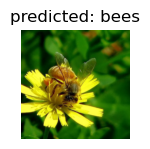

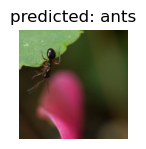

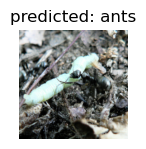

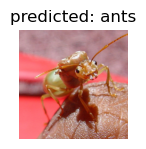

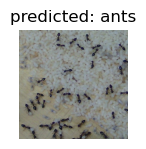

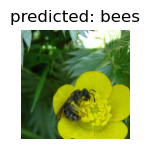

In [11]:
visualize_model(model_ft)

## Layer freezing

In [12]:
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [13]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)


Epoch 0/24
----------
train Loss: 0.6126 Acc: 0.6721
val Loss: 0.2201 Acc: 0.9346

Epoch 1/24
----------
train Loss: 0.4320 Acc: 0.8156
val Loss: 0.1982 Acc: 0.9346

Epoch 2/24
----------
train Loss: 0.4986 Acc: 0.7869
val Loss: 0.1985 Acc: 0.9346

Epoch 3/24
----------
train Loss: 0.5644 Acc: 0.7582
val Loss: 0.3125 Acc: 0.8824

Epoch 4/24
----------
train Loss: 0.4138 Acc: 0.8197
val Loss: 0.2301 Acc: 0.9281

Epoch 5/24
----------
train Loss: 0.4382 Acc: 0.8279
val Loss: 0.1661 Acc: 0.9542

Epoch 6/24
----------
train Loss: 0.5476 Acc: 0.7828
val Loss: 0.1697 Acc: 0.9412

Epoch 7/24
----------
train Loss: 0.3931 Acc: 0.8238
val Loss: 0.1653 Acc: 0.9477

Epoch 8/24
----------
train Loss: 0.3181 Acc: 0.8607
val Loss: 0.1872 Acc: 0.9412

Epoch 9/24
----------
train Loss: 0.4049 Acc: 0.7992
val Loss: 0.1646 Acc: 0.9412

Epoch 10/24
----------
train Loss: 0.3530 Acc: 0.8566
val Loss: 0.1853 Acc: 0.9477

Epoch 11/24
----------
train Loss: 0.3769 Acc: 0.8607
val Loss: 0.1609 Acc: 0.9542

Ep

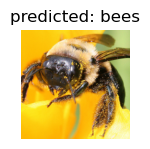

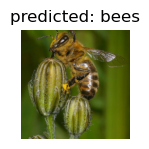

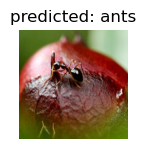

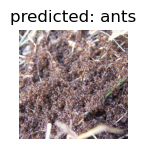

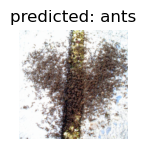

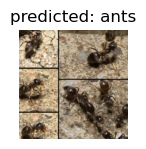

In [14]:
visualize_model(model_conv)

plt.ioff()
plt.show()